In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from rasterio.plot import reshape_as_image
from tqdm import tqdm

import numpy as np
import progressbar
import pandas as pd
import torch
import xarray as xr

from data.satellite import SatelliteData, BANDS_WITH_NO_AIR, RGB_BANDS, Normalization

%matplotlib inline 

Band info for reference: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

## Load test data

In [30]:
kwargs = {
    "data_root": "../Arizona-processed4",
    "seq_len": 60,
    "no_randomization": True,
    "bands_to_keep": RGB_BANDS
}

test_data_z = SatelliteData(train=False, **kwargs, normalization=Normalization.Z)
test_data_minmax = SatelliteData(train=False, **kwargs, normalization=Normalization.MINMAX)
test_data_unnormalized = SatelliteData(train=False, normalization=Normalization.SKIP, **kwargs)
test_data_clipped5 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP5_MINMAX)
test_data_clipped4 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP4_MINMAX)
test_data_clipped3 = SatelliteData(train=False, **kwargs, normalization=Normalization.CLIP3_MINMAX)

Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing
Using: 556 for testing


In [3]:
loaded_test_data = np.array([t.numpy() for t in tqdm(test_data)])

100%|██████████| 556/556 [00:27<00:00, 19.97it/s]


In [3]:
def check_data(tile, month=7, for_viewing=True):
    tile_np = tile.numpy()
    print(f"Mean: {tile_np.mean()}\nMax: {tile_np.max()}\nMin: {tile_np.min()}\nSTD: {tile_np.std()}")
    
    # Visualize image as test
    if for_viewing:
        img = test_data_unnormalized.for_viewing(tile_np[month])
    else:
        img = tile_np[month]
    
    plt.imshow(reshape_as_image(img))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean: 1.0397545002050466
Max: 19.719345243367385
Min: -2.163967016701922
STD: 1.5003189871511615


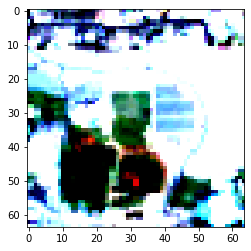

In [5]:
check_data(test_data_z[2], for_viewing=False)

Mean: 0.09201785824917116
Max: 0.36996534809414516
Min: 0.02259124251833851
STD: 0.028132868306465525


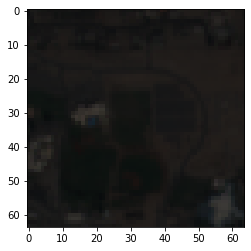

In [21]:
check_data(test_data_minmax[2], for_viewing=False)

Mean: 0.19030196004231775
Max: 0.8221
Min: 0.0502
STD: 0.060539061613657366


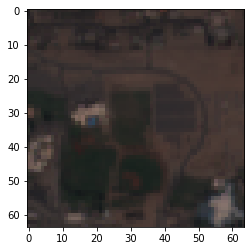

In [24]:
check_data(test_data_unnormalized[2], for_viewing=False)

Mean: 0.2847339108615452
Max: 1.0
Min: 0.078
STD: 0.09750354363279268


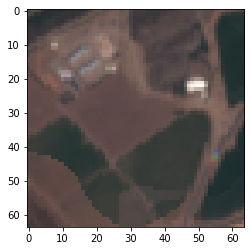

In [29]:
check_data(test_data_clipped5[10], month=53, for_viewing=False)

Mean: 0.35559218716091584
Max: 1.0
Min: 0.09749999999999999
STD: 0.11987935993712932


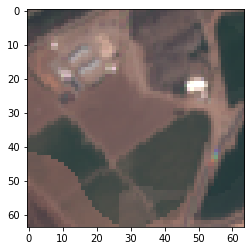

In [85]:
check_data(test_data_clipped4[10], month=53, for_viewing=False)

Mean: 0.4730792295102722
Max: 1.0
Min: 0.13
STD: 0.15541516999658145


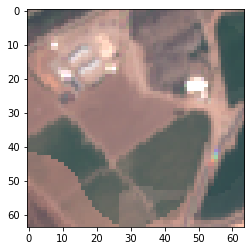

In [86]:
check_data(test_data_clipped3[10], month=53, for_viewing=False)

Text(0.5, 1.0, 'Distribution of Pixel Values for an example time series')

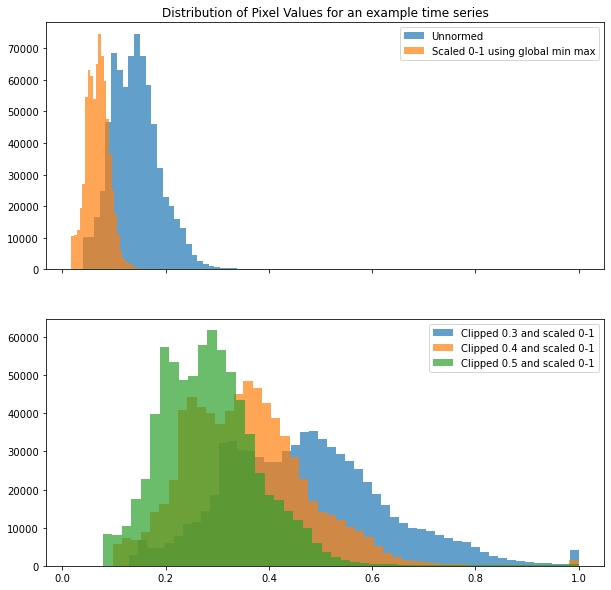

In [87]:
data1 = {
    "Unnormed": test_data_unnormalized, 
    "Scaled 0-1 using global min max": test_data_minmax, 
}

data2 = {
    "Clipped 0.3 and scaled 0-1": test_data_clipped3, 
    "Clipped 0.4 and scaled 0-1": test_data_clipped4, 
    "Clipped 0.5 and scaled 0-1": test_data_clipped5
}
fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True)
for i, data in enumerate([data1, data2]):
    for name, values in data.items():
        #ax = axes[i//3][i%3]
        axes[i].hist(values[10].numpy().flatten(), bins=50, label=name, alpha=0.7)
        axes[i].legend()
        
axes[0].set_title("Distribution of Pixel Values for an example time series")

In [23]:
test_data_clipped3.get_nc(10).y

<xarray.DataArray 'y' (y: 64)>
array([32.757561, 32.757471, 32.757381, 32.757291, 32.757202, 32.757112,
       32.757022, 32.756932, 32.756842, 32.756752, 32.756663, 32.756573,
       32.756483, 32.756393, 32.756303, 32.756213, 32.756124, 32.756034,
       32.755944, 32.755854, 32.755764, 32.755674, 32.755585, 32.755495,
       32.755405, 32.755315, 32.755225, 32.755135, 32.755046, 32.754956,
       32.754866, 32.754776, 32.754686, 32.754596, 32.754507, 32.754417,
       32.754327, 32.754237, 32.754147, 32.754057, 32.753968, 32.753878,
       32.753788, 32.753698, 32.753608, 32.753518, 32.753429, 32.753339,
       32.753249, 32.753159, 32.753069, 32.75298 , 32.75289 , 32.7528  ,
       32.75271 , 32.75262 , 32.75253 , 32.752441, 32.752351, 32.752261,
       32.752171, 32.752081, 32.751991, 32.751902])
Coordinates:
  * y        (y) float64 32.76 32.76 32.76 32.76 ... 32.75 32.75 32.75 32.75

Mean: 0.19030196004231775
Max: 0.8221
Min: 0.0502
STD: 0.060539061613657366


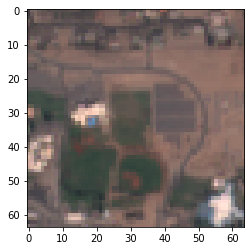

In [41]:
check_data(test_data_unnormalized[2])

In [101]:
#
test = test_data_unnormalized[2].numpy()[7]
threshold = 0.50
test[test > threshold] = threshold
minmax = (test - test.min()) / (test.max() - test.min())

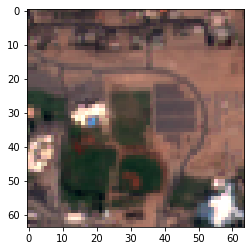

In [100]:
plt.imshow(reshape_as_image(minmax))
plt.show()

In [95]:
model = torch.load("model_dump/satellite/full_ssim_mse_point1.pth")

In [96]:
encoder = model['encoder']
decoder = model['decoder']
encoder.cuda()
decoder.cuda();

In [98]:
model['opt'].normalization

'minmax'

In [90]:
x = test_data_minmax[2][7:8].cuda()

In [94]:
h_target, skip = encoder(x)

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [93]:
skip.dtype

NameError: name 'skip' is not defined

In [91]:
h_target, skip = encoder(x)
h_target.detach()
decoded_h_target= decoder([h_target, skip]).detach()

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

Mean: -0.6003812291169063
Max: 25.82455662761002
Min: -4.709863473706446
STD: 1.3554785279990569


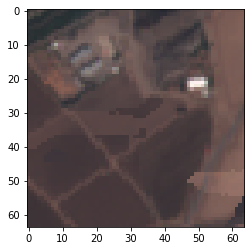

In [5]:
check_data(test_data[10])

## Baseline - utility code

In [6]:
def compute_mse(loaded_test_data, forecast_months=7, baseline_type="all_years", unnormalize=False):
    """
    Computes mean squared error
    """
    total_mse_per_bands = 0

    for test_inst in tqdm(loaded_test_data):
        
        if unnormalize:
            test_inst = test_data.unnormalize(test_inst)
        
        s = test_inst.shape
        test_inst_by_year = test_inst.reshape(-1, 12, s[1], s[2], s[3])

        # Set y to be latest 7 months
        Y_true = test_inst_by_year[-1][-forecast_months:]
        
        if baseline_type == "all_years":
            # Set y pred to be average of all past year's 7 months
            Y_pred = test_inst_by_year[:-1].mean(axis=0)[-forecast_months:]
        elif baseline_type == "last_year":
            # Set y pred to be last year's 7 months
            Y_pred = test_inst_by_year[-2][-forecast_months:]
        elif baseline_type == "last_month":
            Y_pred = test_inst_by_year[-1][-(forecast_months+1)]
        else:
            raise ValueError("baseline_type must be 'all_years', 'last_year', or 'last_month'")
        
        # Calculate mean squared loss per band
        total_mse_per_bands += ((Y_true - Y_pred)**2).mean(axis=(0,-2,-1))
        
    mean_mse_per_bands = total_mse_per_bands / len(loaded_test_data)
        
    return mean_mse_per_bands

In [7]:
def plot_mses(mses, title):
    df = pd.DataFrame(mses)
    df = df.set_index(pd.Index(test_data.bands_to_keep))
    df.plot(kind='bar', figsize=(15,5), 
            title=title,
           xlabel="Band",
           ylabel="MSE");

100%|██████████| 556/556 [00:02<00:00, 199.58it/s]


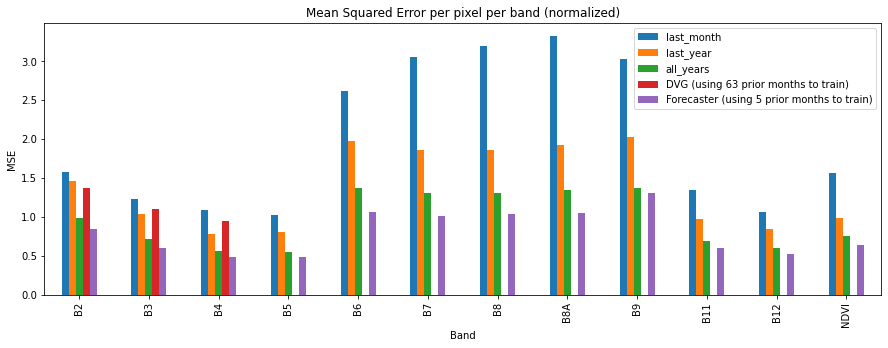

In [8]:
mses = {
    k: compute_mse(loaded_test_data, baseline_type=k)
    for k in ["last_month", "last_year", "all_years"]
}

mses["DVG (using 63 prior months to train)"] = [1.3702908, 1.1102128, 0.94570667] + [0 for i in range(9)]
mses["Forecaster (using 5 prior months to train)"] = [0.84178023, 0.60160971, 0.48618681, 0.48346133, 1.05982456,
       1.01759255, 1.04585694, 1.05148563, 1.31319203, 0.60696182,
       0.52989607, 0.63550722]

plot_mses(mses, title="Mean Squared Error per pixel per band (normalized)")

100%|██████████| 556/556 [00:08<00:00, 68.51it/s]


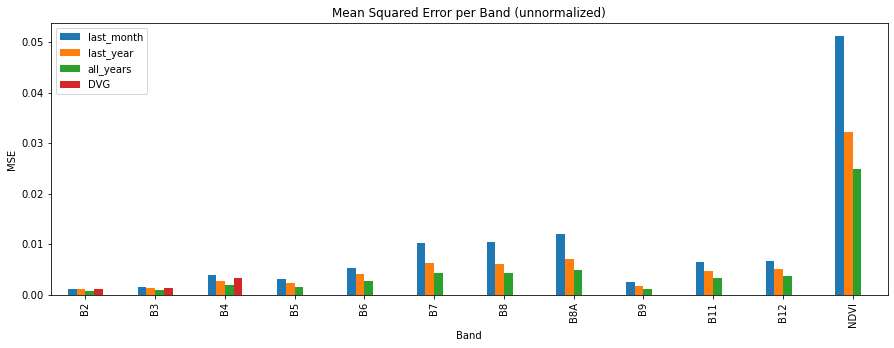

In [11]:
mses = {
    k: compute_mse(loaded_test_data, baseline_type=k, unnormalize=True)
    for k in ["last_month", "last_year", "all_years"]
}

mses["DVG"] = [0.00107829, 0.00145277, 0.0034245] + [0 for i in range(9)]
#mses["Forecaster"] = 

plot_mses(mses, title="Mean Squared Error per Band (unnormalized)")